In [11]:
## Kalman filter
#    counter-current heat exchanger of Model 1
#Filename:Kalman-Filter-Model1.ipynb
#Author:Madhusudhan Pandey, USN, EPE
#Date: March 20, 2019
figpath = "C:/Users/pande/Desktop/Desktop/Thesis/ThesisLyx/figures/chapter3/";

using NLsolve
using DifferentialEquations
using Plots
pyplot();# pyplot attributes on backend
using LaTeXStrings;
using Compat, Random, Distributions
# Linewidths and styles
LW1 = 2 
LW2 = 1.5
LS1 = :solid
LS2 = :dot
LS3 = :dashdot
LS4 = :dash;
# inputs (need to specify first than parameters as Qdfs is input dependent and considered as parameters)

function u_Ifd(t)
    if isless(t, 3000)
        return 1055.
    elseif 3000<t<10000
        return 1.2*1055
    else
        return 0.5*1055
    end
    return 1055.
end
Twc = 3.8
Ifd = 1055.
It = 5360.
QdFes = 212.
Wdf = 528.
mdw = 53.9
mda = 49.2


#
u = [Twc, Ifd, It, QdFes, Wdf, mdw, mda]

#Specifying Parameters
pa = 1.01e5 # " Atmospheric pressure , Pa "
#
chpa = 1.15 # " Specific heat capacity air , kJ.kg -1. K -1 # " 
chpw = 4.2 # " Specific heat capacity water , kJ.kg -1. K -1 # " 
chpCu = 0.385 # " Specific heat capacity copper , kJ.kg -1. K -1 # " 
chpFe = 0.465 # " Specific heat capacity iron , kJ.kg -1. K -1 # " 
#
mr = 9260. # " Mass of copper in rotor , kg # " 
ms = 6827. # " Mass of copper in stator , kg # " 
mFe = 71200. # " Mass of iron in stator , kg # " 
#
VhCu = 0.112e-3 # " Specific volume of copper , m3 / kg # " 
VhFe = 0.127e-3 # " Specific volume of iron , m3 / kg # " 
#
Vr = mr*VhCu # " Rotor copper volume , m3 # " 
Vs = ms*VhCu # " Stator copper volume , m3 # " 
VFe = mFe*VhFe # " Stator iron volume , m3 # " 
#
UAr2d = 2.7 # " Heat transfer , rotor copper to air gap , kW / K # " 
UAs2Fe = 20. # " Heat transfer , stator copper to stator iron , kW /K" 
UAFe2a = 14.3 # " Heat transfer , rotor iron to hot air , kW / K # " 
Up=0.88 # "Product of overall heat transfer and perimeter"
#
Hha_o = 0. # " Enthalpy of formation air , kJ / kg " 
HhCu_o = 0. # " Enthalpy of formation copper , kJ / kg # " 
HhFe_o = 0. # " Enthalpy of formation iron , kJ / kg # " 
#
Ta_o = 25. # " Standard state temperature air , C # " 
TCu_o = 25. # " Standard state temperature copper , C # " 
TFe_o = 25. # " Standard state temperature iron , C # " 
#
Rr = 0.16e-3 # " Ohmic resistance , rotor copper , kOhm, at 25 C # " 
Rs = 3.5e-6 # " Ohmic resistance , stator copper , kOhm, at 25 C"
#
aCu = 2.559380892459937
bCu = 0.0011982506064166993
aFe = 0.19724545575725203
bFe = 0.00676358006431966
aa = 3.2822556593357177
ba = 0.0006721070788120142
aw = 3.6394816337401976
bw = 0.0012723320470041624
alphaCu = 0.00404
R = 8.314 # " J.K-1.mol-1 # "
MCu = 63.54 # " Molecular mass of Copper, g/mol"
MFe = 55.84 # "Molecular mass of Iron, g/mol"
Ma = 28.97 # "Molecular mass of Air, g/mol"
Mw = 18.01 # "Molecular mass of Water, g/mol"
Qdfs = 0.8*Wdf
#tuples of parameters
par = [pa,chpa,chpw,chpCu,chpFe,mr,ms,mFe,VhCu,VhFe,
    Vr,Vs,VFe,UAr2d,UAs2Fe,UAFe2a,Hha_o,HhCu_o,
    HhFe_o,Ta_o,TCu_o,TFe_o,Rr,Rs,aCu,bCu,aFe,bFe,aa,ba,aw,bw,alphaCu,R,MCu,
    MFe,Ma,Mw,Qdfs];
Tr0, Ts0, TFe0 = 94., 81., 70.
temp_of_states = Tr0,Ts0,TFe0
# Finding values for Tac, Tad, Tah
function find_air_temperatures(temp_of_states, par)
    Tr, Ts, TFe= temp_of_states
    function f!(F, x)
        Tac,Tad,Tah = x[1], x[2], x[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,50.0)
        function heat_exchanger!(dT,T,par,t)
            # Counter-current
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc]
        function bc!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc
        end
        bvp=BVProblem(heat_exchanger!,bc!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(50) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
    end
    return nlsolve(f!,temp_of_states).zero #returs Tac, Tad, Tah
end

find_air_temperatures (generic function with 1 method)

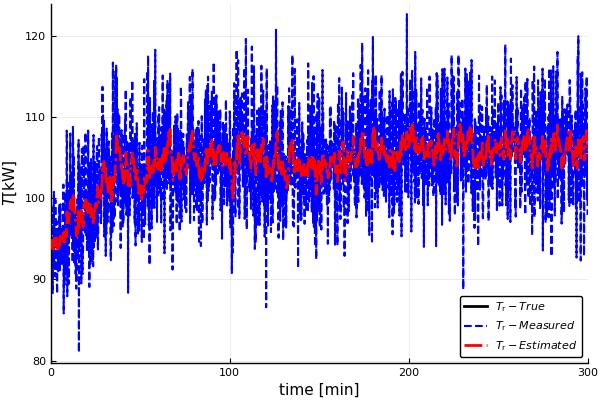

In [12]:
using LinearAlgebra
Q = 10e-2*[1 0 0 
    0 1 0
    0 0 1]
#process noise
wk=10e-2*[1,1,1]
R = [5]
c = [1 0 0]
xhatkminus1plus=[94.,81.,70.]
x = xhatkminus1plus
Pkminus1plus=Q#[10. 0 0; 0 10. 0; 0 0 10.]
dt=10
# for plotting

t_sim=range(0,stop=300*60,step=dt)
xtrue, ymeas, xest=zeros(0),zeros(0),zeros(0)
Tsest, TFeest=zeros(0),zeros(0)
#append!(xtrue,x[1])
#append!(ymeas,c*x+R*rand())
#append!(xest,x[1])

#Tr0, Ts0, TFe0=94.,81.,70.
function xhatkminus(Pk,xhatkminus,iterator)
    # sigma points
    if iterator<4
        xtilde = cholesky(3*Pk).U[iterator,:]
    elseif iterator>3
        xtilde = -cholesky(3*Pk).U[iterator-3,:]
    end
    xhatk =  xhatkminus + xtilde
    #print(xhatkminus1)
    return xhatk
end
for (index,value) in enumerate(t_sim)
    #Tr0, Ts0, TFe0=xhatkminus1plus
    # simulate real system
    #x=xhatkminus1plus
    Tr0, Ts0, TFe0 = x
    Tac0, Tad0, Tah0 = find_air_temperatures([Tr0, Ts0, TFe0], par)
    Tr=Tr0 + dt*(1.1*Rr*u_Ifd(value)^2-UAr2d*(Tr0-Tad0))/(mr*chpCu)
    Ts=Ts0 + dt*(3*Rs*It^2-UAs2Fe*(Ts0-TFe0))/(ms*chpCu)
    TFe=TFe0 + dt*(UAs2Fe*(Ts0-TFe0)-UAFe2a*(TFe0-Tah0)+QdFes)/(mFe*chpFe)
    x=[Tr,Ts,TFe]+wk*rand(Normal())
    
    
    yk=c*x+R*rand(Normal())
    
    xhatminuskmul2n=zeros(3,1)
    yhatminuskmul2n=zeros(1,1)
    xhatk3by6=zeros(3,6)# creating empty for storing all sigma points
    yhatk1by6=zeros(1,6)
    Pminusk=zeros(3,3)
    #print(xhatkminus1plus)
    #print(Pkminus1plus)
    Pxy=zeros(3,1)
    for j=1:(2*length(xhatkminus1plus))
        Tr0, Ts0, TFe0 = xhatkminus(Pkminus1plus,xhatkminus1plus,j)
        Tac0, Tad0, Tah0 = find_air_temperatures([Tr0, Ts0, TFe0], par)
        Tr=Tr0 + dt*(1.1*Rr*u_Ifd(value)^2-UAr2d*(Tr0-Tad0))/(mr*chpCu)
        Ts=Ts0 + dt*(3*Rs*It^2-UAs2Fe*(Ts0-TFe0))/(ms*chpCu)
        TFe=TFe0 + dt*(UAs2Fe*(Ts0-TFe0)-UAFe2a*(TFe0-Tah0)+QdFes)/(mFe*chpFe)
        xhatk=[Tr,Ts,TFe]
        #print(xhatk)
        # calculate rquirements before loop
        yhatk=xhatk[1,1] #measurement is of only Tr state
        #print(yhatk)
        xhatk3by6[:,j] = xhatk
        
        #yhatk=113.28202623352422 + 0.009497842015457714*yhatmeas - 5.65091225345258e-7*yhatmeas^2 + 1.0246407942357915e-11*yhatmeas^3

        yhatk1by6[1,j] = yhatk
        #print(yhatk1by6)
        xhatminuskmul2n= xhatminuskmul2n+xhatk
        #print("hellow\n")
        #print(xhatminuskmul2n)
        yhatminuskmul2n= @. yhatminuskmul2n+yhatk
        #print(yhatminuskmul2n)
        #print("\nhellow")
    end
    xhatminusk=xhatminuskmul2n/(6)
    #print(xhatminusk)
    yhatminusk=yhatminuskmul2n/(6)
    #print(xhatminusk)
    #print("\n")
    #print(yhatminusk)
    Py=zeros(1,1)
    for k=1:6
        Pminusk=Pminusk+(xhatk3by6[:,k]-xhatminusk)*transpose(xhatk3by6[:,k]-xhatminusk)
        #print(Pminusk)
        #print("\n")
        Py=Py+(yhatk1by6[:,k]-yhatminusk)*transpose(yhatk1by6[:,k]-yhatminusk)
        #print(Py)
        #print("\n")
        Pxy=Pxy+(xhatk3by6[:,k]-xhatminusk)*transpose(yhatk1by6[:,k]-yhatminusk)
        #print(Pxy)
        #print("\n\n")
    end
    Pminusk=Pminusk/6+Q
    #print(Pminusk)
    #print("\n")
    Py=Py/6+vec(R)
    #print(Py)
    #print("\n")
    Pxy=Pxy/6
    #print(Pxy)
    #print("\n")
    Kk=Pxy*inv(Py)
    #print(Kk)
    #print("\n")
    # true
    append!(xtrue,x[1])
    append!(ymeas,yk)
    innovation=yk-yhatminusk
    #print(innovation)
    
    xhatkminus1plus= xhatminusk+Kk*innovation
    #print(xhatkminus1plus)
    #print("\n")
    append!(xest,xhatkminus1plus[1])
    append!(Tsest,xhatkminus1plus[2])
    append!(TFeest,xhatkminus1plus[3])
    Pkminus1plus=Pminusk-Kk*Py*transpose(Kk)
    Pkminus1plus=Hermitian(Pkminus1plus)
    
    #print(Pkminus1plus)
    #print("hellow")
end
using JLD
kalman_co_current_model1=[xtrue, ymeas, xest, t_sim]
save("kalman_co_current_model1.jld","kalman_co_current_model1",kalman_co_current_model1)
plot(t_sim/60, xtrue, lc=:black,lw=2,label=L"$T_\mathrm{r}-True$")
plot!(t_sim/60, ymeas, lc=:blue,lw=1.5,ls=:dash,label=L"$T_\mathrm{r}-Measured$" )
plot!(t_sim/60, xest, lc=:red,lw=2,ls=:dashdot,label=L"$T_\mathrm{r}-Estimated$")
#plot!(t_sim/60, xtrue-xest)
#plot!(t_sim/60, Tsest)
#plot!(t_sim/60, TFeest)
plot!(xlim=(0,300))
plot!(xlabel="time [min]",ylabel=L"$T \mathrm{[kW]}$")

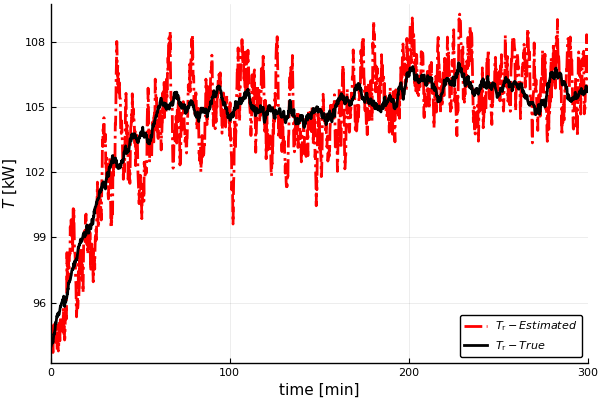

In [13]:

#plot(t_sim/60, ymeas, lc=:blue,lw=1.5,ls=:dash,label=L"$T_\mathrm{r}-Measured$" )
plot(t_sim/60, xest, lc=:red,lw=2,ls=:dashdot,label=L"$T_\mathrm{r}-Estimated$")
plot!(t_sim/60, xtrue, lc=:black,lw=2,label=L"$T_\mathrm{r}-True$")
#plot!(t_sim/60, xtrue-xest)
#plot!(t_sim/60, Tsest)
#plot!(t_sim/60, TFeest)
plot!(xlim=(0,300))
plot!(xlabel="time [min]",ylabel=L"$T$ $\mathrm{[kW]}$")

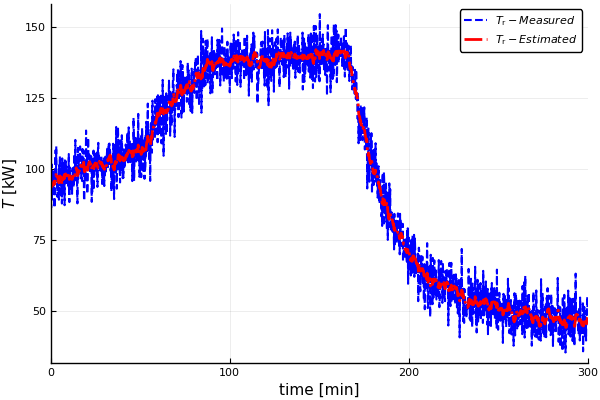

In [10]:
plot(t_sim/60, ymeas, lc=:blue,lw=1.5,ls=:dash,label=L"$T_\mathrm{r}-Measured$" )
plot!(t_sim/60, xest, lc=:red,lw=2,ls=:dashdot,label=L"$T_\mathrm{r}-Estimated$")
#plot!(t_sim/60, xtrue, lc=:black,lw=2,label=L"$T_\mathrm{r}-True$")
#plot!(t_sim/60, xtrue-xest)
#plot!(t_sim/60, Tsest)
#plot!(t_sim/60, TFeest)
plot!(xlim=(0,300))
plot!(xlabel="time [min]",ylabel=L"$T$ $\mathrm{[kW]}$")

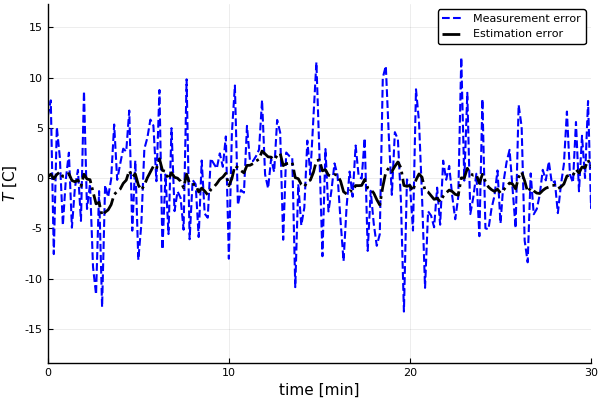

In [9]:
plot(t_sim/60, xtrue-ymeas, lc=:blue,lw=1.5,ls=:dash,label="Measurement error" )
plot!(t_sim/60, xtrue-xest, lc=:black,lw=2,ls=:dashdot,label="Estimation error")
plot!(xlim=(0,30))
plot!(xlabel="time [min]",ylabel=L"$T$ [C]")

25.66282276081912
37.02450305386127
48.74605294991956
[-348.423, 35.6687, 264.686]
-347.42349280276545
20.13816646311054
30.447586477202425
37.38834780922746
20.381289941817446
30.718348996717204
37.88816619341883
20.608472838530812
30.607557424530437
38.35521359235746
19.935123906151322
29.87462084139406
36.970928630787185
19.32918499676627
29.420904980052
35.72522661871378
20.57963014296894
30.791954535961242
38.29591816943877
21.304743682511752
31.754744435447975
39.78662190408796
21.760374607672492
32.4621197192224
40.72331758651617
22.2521888932993
32.79414294633244
41.73439978586348
21.989535933727257
32.35542607232298
41.1944322822951
22.79743852586199
33.15599673076838
42.85533550041331
22.488522246740494
33.06747460259306
42.22025888707276
22.48760909633
32.98394496026861
42.21838161316795
22.394049070121426
32.86651548302598
42.02603893456815
22.777560679574588
33.5625268626892
42.814470204040795
23.28873246454685
34.088198403350724
43.86534795952556
23.141918815690985
34.084

-42.800671657379304
-49.57526649254303
-92.00264537391944
-44.30418399766938
-51.02920741317658
-95.09359781201023
-44.7634302392223
-51.457821830808285
-96.03772593570744
-43.15980476148083
-49.992440154107776
-92.74095879001544
-43.63409335907635
-50.54294452084089
-93.71601131683332
-44.741294827316565
-51.59070753451396
-95.99221949518939
-47.083895096759335
-53.68110076999558
-100.80818661404544
-47.201438694915325
-53.80011572519173
-101.04983522542024
-48.946032506673774
-55.32944223146732
-104.63640804730522
-48.3462372189713
-54.89514672042615
-103.40333621334044
-50.71433353890932
-57.21574429709058
-108.2717186701014
30.884297867778844
46.66393757164538
59.480471790665675
[-348.423, 35.6687, 264.686]
-347.42349280276545
-48.64553557259843
-55.12472418489678
-104.01864010980128
-47.70581417893962
-54.20132475012011
-102.08674100577225
-46.214990179978116
-53.14545902681151
-99.02187353397515
-47.4618032126903
-54.4172764514261
-101.58509810588444
-48.0183391195333
-54.5745294

-59.44613825602841
-65.6467552739109
-126.22274729342976
-57.93901161187385
-64.07940431716386
-123.12436449575586
-57.26294137471669
-63.08877836201136
-121.73448501222694
-54.56001181415659
-60.894890711288575
-116.17774531998087
-50.58564233346018
-56.89222771270481
-108.00715256615763
-47.73996742221164
-54.343753496822124
-102.15695396488188
-41.92267801063685
-49.00960162321484
-90.19764748466388
-41.855457033430596
-48.76220146356553
-90.05945317947635
-44.12393090523068
-50.84469078409871
-94.7230296876847
-39.7425810153137
-46.55829204268221
-85.71575802050756
-41.157042360427035
-48.11242228144666
-88.62363754195785
-40.20007606229817
-47.018955208983435
-86.65628600407108
-36.62797690511361
-43.68288661366139
-79.31268908528173
-39.73639123000826
-46.668566313306435
-85.70303293289567
-41.298848643718564
-48.15009767030647
-88.9151658918628
-38.01932695274176
-45.0851666031005
-82.17305591842079
-38.6058978689895
-45.742806751274
-83.37894079240955
-41.39718392973488
-48.397

-57.31202441037558
-63.50655913038596
-121.83539096070598
-60.58933534905528
-66.43221183564484
-128.57295603078322
-61.859405775280734
-67.99860194157176
-131.1839936385124
-61.97071117538771
-67.79862264713664
-131.4128176403139
-59.7047594161435
-65.66571396372903
-126.75442613855135
-66.85480865432838
-72.44991167187793
-141.45364842889774
-64.53241212582492
-70.28421648059448
-136.67921657433845
-59.94687550569423
-65.92584159568807
-127.25217351088732
-62.91383996556602
-68.70024169197113
-133.35172173361775
-67.1061346314657
-72.64931813093136
-141.97032968272063
-74.60445071615977
-79.852614798831
-157.38552631431244
-74.24339230995008
-79.50920572598243
-156.64325481436973
-77.07936557178178
-82.3117008257153
-162.47350856458442
-66.41700732110955
-72.2999470912141
-140.5536071915869
-63.69845895142135
-69.57641100337045
-134.96475802199274
-63.78012688263302
-69.30903330961384
-135.1326526806659
-59.6054548295487
-65.7104774477833
-126.55027367131976
-53.53305521748526
-59.70

-42.83040397810008
-49.914996913214445
-92.06376970704255
-45.8930961469572
-52.920116727303544
-98.36011697645111
-48.70100394213089
-55.2262593231154
-104.13267314144821
-57.663090638613255
-63.945418456045495
-122.55712032925705
-53.48877998030585
-59.74216565151073
-113.97548428292755
-50.27512483955526
-56.50899497353243
-107.36878414898025
-51.503992594445585
-57.71772269220379
-109.89511644645108
-48.631048884859524
-55.0212334276091
-103.98885806259398
-52.95160354385835
-59.16572967153154
-112.87114562557741
-52.07411284023381
-58.70570959877952
-111.06718167696899
-54.71833145360703
-61.03677174858922
-116.50322217974463
-61.957346461464695
-67.90497658260256
-131.3853421790595
-61.05536235937581
-67.07933473518048
-129.5310242048353
-65.88053950110805
-71.48230603229484
-139.45072532307378
-66.9579494420936
-72.86484745628997
-141.66568743954764
-67.7979066417994
-73.36034637745074
-143.39248921046055
-64.75119820072331
-70.48220591135937
-137.12900161322364
-74.216997659955

-33.95594351459526
-41.14109536935914
-73.81946638622749
-26.33714323247953
-33.934576045632554
-58.15657579590113
-27.15062912113138
-34.80865451883921
-59.82895727316354
-34.37632891863174
-41.69600706364779
-74.68370357736198
-46.69417661510526
-53.3072738809701
-100.00699513563345
-48.14667414256346
-54.70034690442771
-102.99307023349523
-62.56624507846936
-68.32707173501207
-132.63712882072855
-56.825247258116626
-62.98568981323677
-120.83466420564707
-66.39475194232794
-72.17933008567336
-140.50785412027474
48.80631282961672
80.04100109152084
96.32492880607631
[-348.423, 35.6687, 264.686]
-347.42349280276545
-51.7996696587758
-58.13496639833306
-110.50297559653659
-48.03444803613683
-54.514836464733406
-102.76235343278613
-41.905220841200965
-49.03193417172218
-90.16175866690197
-45.644966624332376
-52.683317264117
-97.85000706134922
-49.29054228369245
-55.78899667829246
-105.34465852147089
-60.598600679455906
-66.7471778403039
-128.59200389670855
-55.5014670447019
-61.6631758992

-171.60658311092402
-73.63329609855153
-79.0992595621249
-155.3890061328461
-62.11267172081107
-67.89421468876232
-131.7046631289417
-52.47904156647939
-58.866914028048164
-111.8996427179942
-32.89762534238599
-40.395640022393046
-71.64375352760987
-33.175453209066276
-40.477421069840375
-72.21491792888587
-38.996502550999026
-45.95040859456383
-84.18195414246294
-24.969176280954173
-32.45748765669909
-55.34428044000831
-28.671438871896875
-36.19526566710468
-62.95547009438791
-26.650059029279628
-34.08587510975406
-58.799874702264866
-17.64287447971699
-25.5623061767921
-40.28271440083576
-26.345935409658463
-33.88749984089492
-58.174650949155236
-31.706770497981182
-38.99416482325698
-69.19556897805064
-22.501488444772143
-30.273440526901094
-50.271155643400704
-23.38646175357217
-31.21569922281302
-52.09050246710797
-32.25700805028913
-39.67291302362533
-70.32675895927906
-47.17590073027592
-53.76674790352718
-100.9973337330436
-48.97792349828795
-55.49340139523006
-104.701970221660

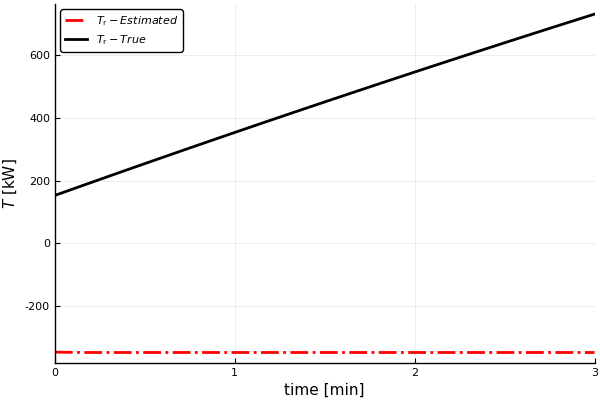

In [55]:
# Finding values for Tac, Tad, Tah
function find_air_temperatures(temp_of_states, par)
    Tr, Ts, TFe= temp_of_states
    function f!(F, x)
        Tac,Tad,Tah = x[1], x[2], x[3]
        F[1] = mda*chpa*(Tac-Tad)+UAr2d*(Tr-Tad)+Qdfs
        F[2] = mda*chpa*(Tad-Tah)+UAFe2a*(TFe-Tah)
        # solving for Tac function
        #length span of heat exchanger
        xspan=(0.0,50.0)
        function heat_exchanger!(dT,T,par,t)
            # Counter-current
            dT[1]=Up/(chpa*mda)*(T[2]-T[1])
            dT[2]=Up/(chpw*mdw)*(T[2]-T[1])
        end
        #initialGuess=[Tah,Twh]
        initial_guess=[Ta_o,Twc]
        function bc!(residual,T,par,t)
            residual[1]=T[1][1]-Tah
            residual[2]=T[end][2]-Twc
        end
        bvp=BVProblem(heat_exchanger!,bc!,initial_guess,xspan,par)
        sol=solve(bvp, Shooting(Vern7()))
        a,b=sol(50) #solves for Tac,Twc
        c,d=sol(0) #solves for Tah,Twh
        F[3] = Tac - a
    end
    return nlsolve(f!,temp_of_states).zero #returs Tac, Tad, Tah
end

# Ensemble kalman filter
c=[1 0 0]
#Initialization
#states: mean=x0, var=0.1^2
x0=[94.,81.,70.]
# store initial in simulation x for plotting real system
x=x0
#process noise: mean=1, var=0.1^2
wk0=1e-2*[1.,1.,1.]
#meas noise: mean=1, var=0.1^2
vk0=1.
# random points
np=50
# initial realization/particles
x00=zeros(3,np)
wk=zeros(3,np)
vk=zeros(np)
#Create random of x0~(mean=x0, var=X0)
# where mean(x)=[[94.,81.,70.], sd=[0.1,0.1,0.1], var=[0.1^2,.,.]]
# This function will generate random random values for w and x
function random_xw(xw;sd=standard_deviation)
    #unpacking x
    xw[1],xw[2],xw[3]=xw
    xw[1]=rand(Normal(xw[1],sd))
    xw[2]=rand(Normal(xw[2],sd))
    xw[3]=rand(Normal(xw[3],sd))
    return [xw[1],xw[2],xw[3]]  
end
#This function will genrate random for v
function random_v(v;sd=standard_deviation)
    return rand(Normal(v,sd))
end
#This function returns f(xk,wk)
function process_f(x_state,w_noise)
    Tr0, Ts0, TFe0 = x_state
    Tac0, Tad0, Tah0 = find_air_temperatures(x_state, par)#[Tr0, Ts0, TFe0]
    print(Tac0)
    print("\n")
    print(Tad0)
    print("\n")
    print(Tah0)
    print("\n")
    Tr=Tr0 + dt*(1.1*Rr*Ifd^2-UAr2d*(Tr0-Tad0))/(mr*chpCu)
    Ts=Ts0 + dt*(3*Rs*It^2-UAs2Fe*(Ts0-TFe0))/(ms*chpCu)
    TFe=TFe0 + dt*(UAs2Fe*(Ts0-TFe0)-UAFe2a*(TFe0-Tah0)+QdFes)/(mFe*chpFe)
    xkkminus1= [Tr,Ts,TFe]+w_noise
    return xkkminus1
end
#
#
#--Alg0rithm starts--
#
#
# Initialization
# calculating x00(i), wk(i),vk(i)
for i=1:np
    x00[:,i]=random_xw(x0;sd=3)
    wk[:,i]=random_xw(wk0;sd=3)
    vk[i]=random_v(vk0;sd=3)
end
xhat00mulnp=zeros(3,1)
X00mulnpminus1=zeros(3,3)
# calculate xhat00
for i=1:np
    xhat00mulnp=xhat00mulnp+x00[:,i]
end
xhat00=xhat00mulnp/np
#calculate X00
for i=1:np
    X00mulnpminus1=X00mulnpminus1+(x00[:,i]-xhat00)*transpose(x00[:,i]-xhat00)
end
X00=X00mulnpminus1/(np-1)
dt=10
t_sim=range(0,step=dt,stop=3*60)
xtrue, ymeas, xest=zeros(0),zeros(0),zeros(0)
Tsest, TFeest=zeros(0),zeros(0)
for i=1:length(t_sim)
    # Simulating model
    #Tr0, Ts0, TFe0=states
    x=process_f(x,wk0)#[Tr0, Ts0, TFe0]
    print(states)
    print("\n")
    # Our measurement is only Tr
    yk=states[1]+vk0
    print(yk)
    print("\n")
    # Propagation step
    #
    xkkminus1=zeros(3,np)
    for i=1:np
        xkkminus1[:,i]=process_f(x00[:,i],wk[:,i])
    end
    xhatkkminus1mulnp=zeros(3,1)
    Xkkminus1mulnpminus1=zeros(3,3)
    #calulate xhatkkminus1
    for i=1:np
        xhatkkminus1mulnp=xhatkkminus1mulnp+xkkminus1[:,i]
    end
    xhatkkminus1=xhatkkminus1mulnp/np
    #calculate Xkkminus1: this is redundanat and can be ommited
    for i=1:np
        Xkkminus1mulnpminus1=Xkkminus1mulnpminus1+(xkkminus1[:,i]-xhatkkminus1)*transpose(xkkminus1[:,i]-xhatkkminus1)
    end
    Xkkminus1=Xkkminus1mulnpminus1/(np-1)

    # Information update
    # Measurement and innovation
    # find ykkminus1 from xkkminus1 and vk
    ykkminus1=zeros(1,np)
    for i=1:np
    # measured state is Tr
        ykkminus1[1,i]=xkkminus1[1,i]+vk[i]
    end
    #calculate yhatkkminus1
    yhatkkminus1mulnp=zeros(1,1)
    for i=1:np
        yhatkkminus1mulnp=@. yhatkkminus1mulnp+ykkminus1[1,i]
    end
    yhatkkminus1=yhatkkminus1mulnp/np

    # Cross and innovation covariance
    #calculate Zkkminus1
    Zkkminus1mulnpminus1=zeros(3,1)
    ekkminus1mulnpminus1=zeros(1,1)
    for i=1:np
        Zkkminus1mulnpminus1= @. Zkkminus1mulnpminus1+(xkkminus1[:,i]-xhatkkminus1)*transpose(ykkminus1[1,i]-yhatkkminus1)
    end
    Zkkminus1=Zkkminus1mulnpminus1/(np-1)
    # calculate innovation covariance
    for i=1:np
        ekkminus1mulnpminus1= @. ekkminus1mulnpminus1+(ykkminus1[1,i]-yhatkkminus1)*transpose(ykkminus1[1,i]-yhatkkminus1)
    end
    ekkminus1=ekkminus1mulnpminus1/(np-1)

    # Compute Kalman gain
    Kk=Zkkminus1*inv(ekkminus1)

    # a posteriori state esitmate
    # store in initializer x00
    for i=1:np
        x00[:,i]=@. xkkminus1[:,i]+Kk*(yk-ykkminus1[1,i])
    end
    # store in initializer xhat00
    xhatkkmulnp=zeros(3,1)
    for i=1:np
        xhatkkmulnp=xhatkkmulnp+x00[:,i]
    end
    xhat00=xhatkkmulnp/np
    # store in X00
    Xkkmulnpminus1=zeros(3,3)
    for i=1:np
        Xkkmulnpminus1=Xkkmulnpminus1+(x00[:,i]-xhat00)*transpose(x00[:,i]-xhat00)
    end
    X00=Xkkmulnpminus1/(np-1)
    # for plotting
    append!(xtrue,x[1])
    append!(ymeas,yk)
    append!(xest,xhat00[1])
    #print(xhat00)
    #print("\n")
    #print(X00)
    #print("\n")
    # end of K=0, initial step
end
#print(length(xest))
#print("\n")
#print(length(t_sim))
plot(t_sim/60, ymeas, lc=:blue,lw=1.5,ls=:dash,label=L"$T_\mathrm{r}-Measured$" )
plot(t_sim/60, xest, lc=:red,lw=2,ls=:dashdot,label=L"$T_\mathrm{r}-Estimated$")
plot!(t_sim/60, xtrue, lc=:black,lw=2,label=L"$T_\mathrm{r}-True$")
#plot!(t_sim/60, xtrue-xest)
#plot!(t_sim/60, Tsest)
#plot!(t_sim/60, TFeest)
plot!(xlim=(0,3))
plot!(xlabel="time [min]",ylabel=L"$T$ $\mathrm{[kW]}$")

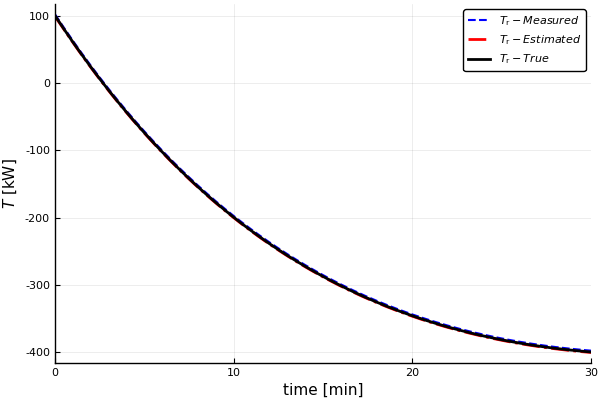

In [8]:
plot(t_sim/60, ymeas, lc=:blue,lw=1.5,ls=:dash,label=L"$T_\mathrm{r}-Measured$" )
plot!(t_sim/60, xest, lc=:red,lw=2,ls=:dashdot,label=L"$T_\mathrm{r}-Estimated$")
plot!(t_sim/60, xtrue, lc=:black,lw=2,label=L"$T_\mathrm{r}-True$")
#plot!(t_sim/60, xtrue-xest)
#plot!(t_sim/60, Tsest)
#plot!(t_sim/60, TFeest)
plot!(xlim=(0,30))
plot!(xlabel="time [min]",ylabel=L"$T$ $\mathrm{[kW]}$")

In [367]:
plot(t_sim/60, xtrue-ymeas, lc=:blue,lw=1.5,ls=:dash,label="Measurement error" )
plot!(t_sim/60, xtrue-xest, lc=:red,lw=2,ls=:dashdot,label="Estimation error")
plot!(xlim=(0,30))
plot!(xlabel="time [min]",ylabel=L"$T$ [C]")

DimensionMismatch: DimensionMismatch("dimensions must match")

In [49]:
find_air_temperatures([94.,81.,70.], par)

3-element Array{Float64,1}:
 21.052275330230287
 31.500299227132754
 39.267592131365284